In [1]:
# import functions!
from racecar_utils import *

# racecar-mn starter class

In [2]:
# Starter code class that handles the fancy stuff. No need to modify this! 
class Racecar:
    SCAN_TOPIC = "/scan"
    IMAGE_TOPIC = "/camera"
    DRIVE_TOPIC = "/drive"
    
    def __init__(self):
        self.sub_scan = rospy.Subscriber(self.SCAN_TOPIC, LaserScan, callback=self.scan_callback)
        self.sub_image = rospy.Subscriber(self.IMAGE_TOPIC, Image, callback=self.image_callback)
        self.pub_drive = rospy.Publisher(self.DRIVE_TOPIC, AckermannDriveStamped, queue_size=1)
        self.last_drive = AckermannDriveStamped()
    
    def image_callback(self, msg):
        self.last_image = msg.data
        
    def show_last_image(self):
        im = np.fromstring(self.last_image,dtype=np.uint8).reshape((480,-1,3))[...,::-1]
        return im
        
    def scan_callback(self, msg):
        self.last_scan = msg.ranges
        
    def drive(self, speed, angle):
        msg = AckermannDriveStamped()
        msg.drive.speed = speed
        msg.drive.steering_angle = angle
        self.last_drive = msg
    
    def stop(self):
        self.drive(0, 0) #self.last_drive.drive.steering_angle)
    
    def look(self):
        return self.last_image
    
    def scan(self):
        return self.last_scan
    
    def run(self, func, param, limit=10):
        r = rospy.Rate(60)
        t = rospy.get_time()
        cap = cv2.VideoCapture(1)
        while rospy.get_time() - t < limit and not rospy.is_shutdown():
            func(cap.read()[1], param)
            self.pub_drive.publish(self.last_drive)
            r.sleep()
        cap.release()
        print("END OF ROSPY RUN")
        self.stop()
        self.pub_drive.publish(self.last_drive)
        time.sleep(0.1)
    
rospy.init_node('racecar')
rc = Racecar()
print('ROS started sucessfully')

ROS started sucessfully


# Part 0: Get HSV Values of Cone

In [3]:
hsv_lower = np.array([2, 60, 232])
hsv_upper = np.array([20, 255, 255])
colorRange = (hsv_lower, hsv_upper)

min_size = 100
video = False # toggle video or image

# Part 1: Cone Identification (image works, video meh)

### Find the greatest contour.
Finish the helper function "find_greatest_contour". This function should return the contour with the biggest area from the list of contours.

In [4]:
def find_contours(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, hsv_lower, hsv_upper)
    contours = cv2.findContours(mask, 3, 2)[1]
    return contours, mask

def check_contours_exist(contours, min_size):
    if contours == []:
        return False
    else:
        greatest_contour = find_greatest_contour(contours)
        if cv2.contourArea(greatest_contour) < min_size:
            return False 
        area = cv2.contourArea(greatest_contour)
        print('Contour Area:{}'.format(area))
    
def draw_contours(contours, mask):
    color_mask = cv2.bitwise_and(img, img, mask=mask)
    cv2.drawContours(img, [greatest_contour], 0, (0,255, 0), 2)    # draw contour
    #x,y,w,h = cv2.boundingRect(cnt)                               # draw rectangle
    #cv2.rectangle(img, (x,y),(x+w,y+h),(0,255, 0),4)
    return img

## Let's test our functions!

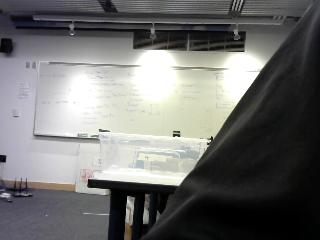

In [5]:
def identify_cone(img, param):
    global last_time
    colorRange, min_range = param 
    (hsv_lower, hsv_upper) = colorRange
    
    # student helper functions
    contours, mask = find_contours(img)
    contours_exist = check_contours_exist(contours, min_size)
    if contours_exist:
        img = draw_contours()
        if video: staggered_video(img, last_time)
            
    return img

# display image or video
if video: 
    show_identified_video(colorRange, min_size, identify_cone, rc)
else: 
    show_identified_image(colorRange, min_size, identify_cone) 

# Part 2: Cone Following WORKS

In [ ]:
def get_speed_angle(contour, sizeRange, screen_center=320.0):
    # find speed 
    res = [0, 0]
    speed =.215
    box_area = cv2.contourArea(contour)
    if box_area > sizeRange[2]:
        print('negative speed')
        res[0] = -speed
    elif box_area < sizeRange[1]:
        print('positive speed')
        res[0] = speed
    else:
        return res 
    
    res = get_mome
    return res 

def cone_follow(img, color_size_ranges):
    #print(img, color_size_ranges, stop_turn_angle)
    colorRange, sizeRange = color_size_ranges
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, colorRange[0], colorRange[1])
    ctImg, contours, __ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    res = [0, 0]
    if contours == [] or contours is None: 
        # stop driving
        print("No Contour") 
        return img
    
    cnt = find_greatest_contour(contours)
    print(cv2.contourArea(cnt))
    if cv2.contourArea(cnt) < sizeRange[0]:
        # stop driving 
        print("Too Small") 
        return img
    res = get_speed_angle(cnt, sizeRange, screen_center=img.shape[1]/2.0)

    if res[0] == 0:
        print('Right place to take control over!!')
    img = cv2.drawContours(img, [cnt], 0, (0,255, 0), 2)
    print(res)
    rc.drive(res[0], res[1])
    # draw box?
    
    return img


In [ ]:
ipython_display()

def student_code(frame, params):
    global last_time
    frame = cv2.resize(frame, (480, 640))
    img = cone_follow(frame, params)
    
    # show video
    staggered_video(img, last_time)

# too small, range to stop: min to max
rc.run(student_code, (colorRange, [100, 12000, 30000]), limit=15) 